<a href="https://colab.research.google.com/github/indhu68/Intro_To_DL/blob/main/DL_HW5_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
text ='Next character prediction is a fundamental task in the field of natural language processing (NLP) that involves predicting the next character in a sequence of text based on the characters that precede it. This task is essential for various applications, including text auto-completion, spell checking, and even in the development of sophisticated AI models capable of generating human-like text. At its core, next character prediction relies on statistical models or deep learning algorithms to analyze a given sequence of text and predict which character is most likely to follow. These predictions are based on patterns and relationships learned from large datasets of text during the training phase of the model. One of the most popular approaches to next character prediction involves the use of Recurrent Neural Networks (RNNs), and more specifically, a variant called Long Short-Term Memory (LSTM) networks. RNNs are particularly well-suited for sequential data like text, as they can maintain information in "memory" about previous characters to inform the prediction of the next character. LSTM networks enhance this capability by being able to remember long-term dependencies, making them even more effective for next character prediction tasks. Training a model for next character prediction involves feeding it large amounts of text data, allowing it to learn the probability of each characters appearance following a sequence of characters. During this training process, the model adjusts its parameters to minimize the difference between its predictions and the actual outcomes, thus improving its predictive accuracy over time. Once trained, the model can be used to predict the next character in a given piece of text by considering the sequence of characters that precede it. This can enhance user experience in text editing software, improve efficiency in coding environments with auto-completion features, and enable more natural interactions with AI-based chatbots and virtual assistants. In summary, next character prediction plays a crucial role in enhancing the capabilities of various NLP applications, making text-based interactions more efficient, accurate, and human-like. Through the use of advanced machine learning models like RNNs and LSTMs, next character prediction continues to evolve, opening new possibilities for the future of text-based technology.'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10, Loss: 2.517825126647949, Validation Loss: 2.4486403465270996, Validation Accuracy: 0.28421053290367126
Epoch 20, Loss: 2.3301162719726562, Validation Loss: 2.3571395874023438, Validation Accuracy: 0.2821052670478821
Epoch 30, Loss: 2.254483699798584, Validation Loss: 2.282134771347046, Validation Accuracy: 0.30105262994766235
Epoch 40, Loss: 2.222100019454956, Validation Loss: 2.266822576522827, Validation Accuracy: 0.31368422508239746
Epoch 50, Loss: 2.2021450996398926, Validation Loss: 2.2654144763946533, Validation Accuracy: 0.3073684275150299
Epoch 60, Loss: 2.207186698913574, Validation Loss: 2.276723861694336, Validation Accuracy: 0.3094736933708191
Epoch 70, Loss: 2.1940758228302, Validation Loss: 2.2793657779693604, Validation Accuracy: 0.31578946113586426
Epoch 80, Loss: 2.200700283050537, Validation Loss: 2.2763562202453613, Validation Accuracy: 0.3115789592266083
Epoch 90, Loss: 2.1957011222839355, Validation Loss: 2.27785587310791, Validation Accuracy: 0.305263161

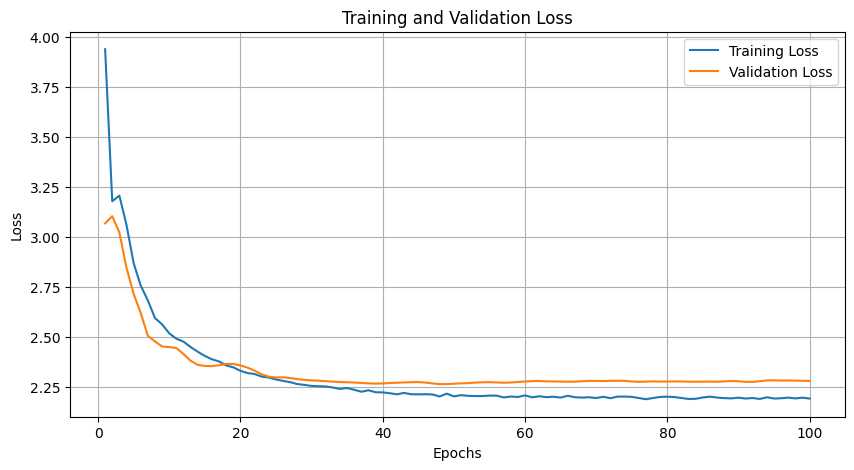

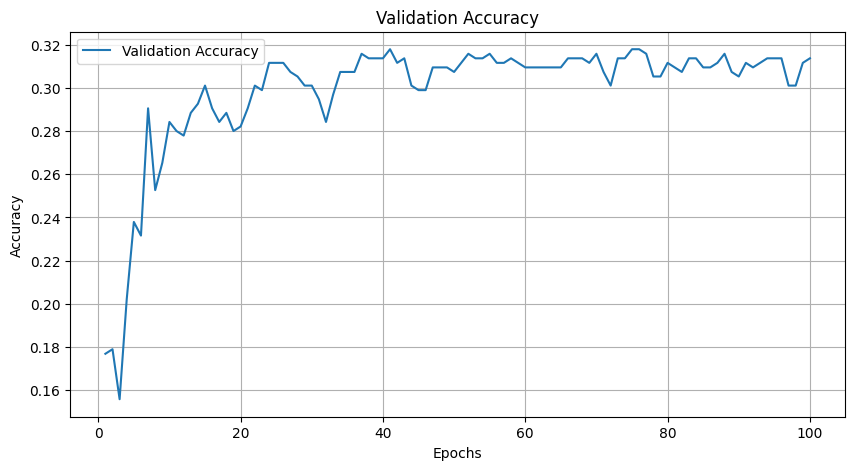

In [ ]:
# Create character vocabulary
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 10  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 256
num_layers = 3
nhead = 2
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    # Append loss and accuracy values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print loss and accuracy values
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)

embedding_complexity = X_train.shape[1] * hidden_size
rnn_complexity = X_train.shape[1] * hidden_size * hidden_size
linear_complexity = hidden_size * len(chars)
total_complexity = embedding_complexity + rnn_complexity + linear_complexity

# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"Trainable parameters: {count_parameters(model)}")
print(f"Total computational complexity: {total_complexity}")


# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 10, Loss: 2.5220630168914795, Validation Loss: 2.5315821170806885, Validation Accuracy: 0.260042279958725
Epoch 20, Loss: 2.319272994995117, Validation Loss: 2.447113275527954, Validation Accuracy: 0.25792813301086426
Epoch 30, Loss: 2.2413809299468994, Validation Loss: 2.4033820629119873, Validation Accuracy: 0.2706131041049957
Epoch 40, Loss: 2.2054924964904785, Validation Loss: 2.4089722633361816, Validation Accuracy: 0.2706131041049957
Epoch 50, Loss: 2.189037561416626, Validation Loss: 2.413365364074707, Validation Accuracy: 0.2811839282512665
Epoch 60, Loss: 2.1794772148132324, Validation Loss: 2.4252896308898926, Validation Accuracy: 0.27272728085517883
Epoch 70, Loss: 2.178166627883911, Validation Loss: 2.435007095336914, Validation Accuracy: 0.2875264286994934
Epoch 80, Loss: 2.178873062133789, Validation Loss: 2.4399945735931396, Validation Accuracy: 0.2832981050014496
Epoch 90, Loss: 2.174410581588745, Validation Loss: 2.4461164474487305, Validation Accuracy: 0.2832981

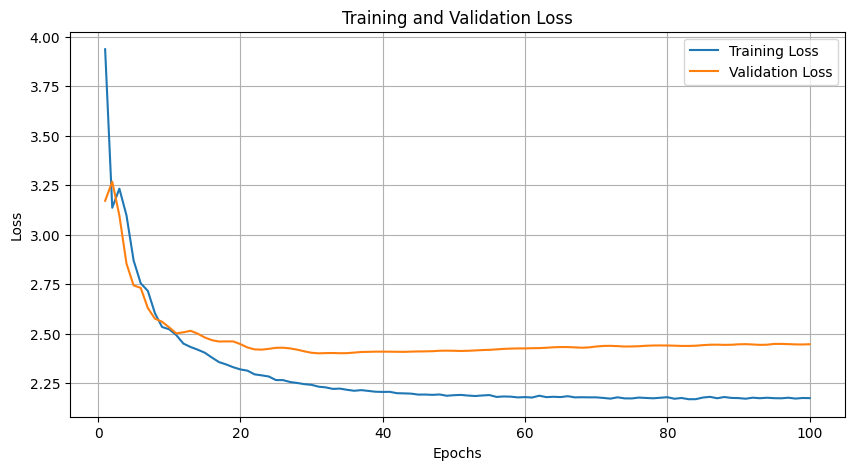

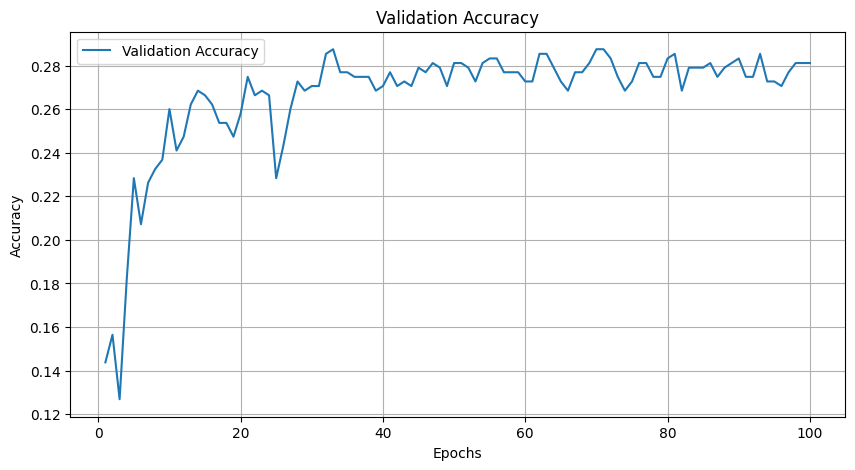

In [ ]:
# Create character vocabulary
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 20  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 256
num_layers = 3
nhead = 2
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    # Append loss and accuracy values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print loss and accuracy values
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)

embedding_complexity = X_train.shape[1] * hidden_size
rnn_complexity = X_train.shape[1] * hidden_size * hidden_size
linear_complexity = hidden_size * len(chars)
total_complexity = embedding_complexity + rnn_complexity + linear_complexity

# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"The trainable parameters count in the model: {count_parameters(model)}")
print(f"Total computational complexity: {total_complexity}")


# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()



Epoch 10, Loss: 2.622981071472168, Validation Loss: 2.5801541805267334, Validation Accuracy: 0.24628449976444244
Epoch 20, Loss: 2.384347915649414, Validation Loss: 2.4359209537506104, Validation Accuracy: 0.23779192566871643
Epoch 30, Loss: 2.269819498062134, Validation Loss: 2.3816659450531006, Validation Accuracy: 0.2717622220516205
Epoch 40, Loss: 2.220233917236328, Validation Loss: 2.3862507343292236, Validation Accuracy: 0.25902336835861206
Epoch 50, Loss: 2.2030255794525146, Validation Loss: 2.399951219558716, Validation Accuracy: 0.25265392661094666
Epoch 60, Loss: 2.200033664703369, Validation Loss: 2.4115278720855713, Validation Accuracy: 0.25690022110939026
Epoch 70, Loss: 2.187873125076294, Validation Loss: 2.422173500061035, Validation Accuracy: 0.25902336835861206
Epoch 80, Loss: 2.1822104454040527, Validation Loss: 2.417431592941284, Validation Accuracy: 0.25477707386016846
Epoch 90, Loss: 2.1865856647491455, Validation Loss: 2.4233789443969727, Validation Accuracy: 0.25

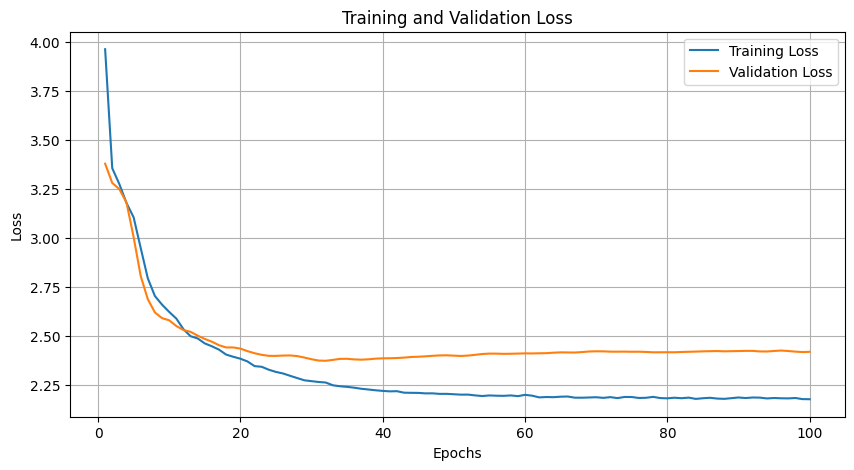

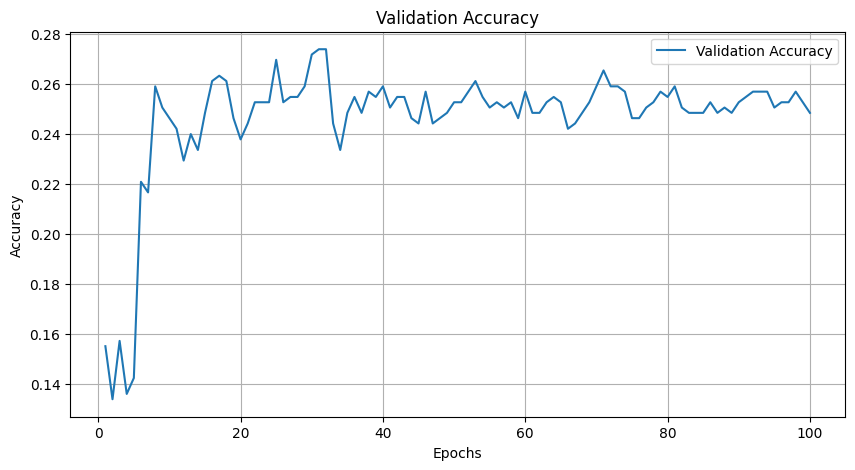

In [ ]:
# Create character vocabulary
chars = sorted(set(text))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Preparing the dataset
max_length = 30  # Maximum length of input sequences
X = []
y = []
for i in range(len(text) - max_length):
    sequence = text[i:i + max_length]
    label = text[i + max_length]
    X.append([char_to_ix[char] for char in sequence])
    y.append(char_to_ix[label])

X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Defining the Transformer model
class CharTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, nhead):
        super(CharTransformer, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)
        encoder_layers = nn.TransformerEncoderLayer(hidden_size, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        transformer_output = self.transformer_encoder(embedded)
        output = self.fc(transformer_output[:, -1, :])  # Get the output of the last Transformer block
        return output

# Hyperparameters
hidden_size = 256
num_layers = 3
nhead = 2
learning_rate = 0.001
epochs = 100

# Model, loss, and optimizer
model = CharTransformer(len(chars), hidden_size, len(chars), num_layers, nhead)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
start_time = time.time()
# Lists to store loss and accuracy values
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    end_time = time.time()
    training_time = end_time - start_time

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        _, predicted = torch.max(val_output, 1)
        val_accuracy = (predicted == y_val).float().mean()

    # Append loss and accuracy values
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy.item())

    # Print loss and accuracy values
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}, Validation Accuracy: {val_accuracy.item()}')

# Prediction function
def predict_next_char(model, char_to_ix, ix_to_char, initial_str):
    model.eval()
    with torch.no_grad():
        initial_input = torch.tensor([char_to_ix[c] for c in initial_str[-max_length:]], dtype=torch.long).unsqueeze(0)
        prediction = model(initial_input)
        predicted_index = torch.argmax(prediction, dim=1).item()
        return ix_to_char[predicted_index]

# Counting model complexity
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Predicting the next character and computing the computational complexity
test_str = "One of the most popular approaches to next character predi"
predicted_char = predict_next_char(model, char_to_ix, ix_to_char, test_str)

embedding_complexity = X_train.shape[1] * hidden_size
rnn_complexity = X_train.shape[1] * hidden_size * hidden_size
linear_complexity = hidden_size * len(chars)
total_complexity = embedding_complexity + rnn_complexity + linear_complexity

# Printing the results
print(f"Predicted next character: '{predicted_char}'")
print(f"Training time:{training_time} seconds")
print(f"The trainable parameters count in the model: {count_parameters(model)}")
print(f"Total computational complexity: {total_complexity}")


# Plotting loss and accuracy graphs
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

